In [1]:
%reload_ext autoreload
%autoreload 2

from common_imports import *

In [2]:
"""
Fidelity is the inner product, except that
 each individual eigenvector product is made to be phase insensitive before summing
"""
def fidelity_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    objective = objectives[0]
    overlap = np.sum(np.abs(np.asarray(fw_states_T))*np.abs(np.asarray(objective.target)))
    return overlap

def J_T_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    J_T = 1-fidelity_custom(fw_states_T,objectives)
    return J_T


# This chi_constructor assumes there is only one objective ....
def chis_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    chis = qt.zero_ket(system.N_points*system.internal_dims,dims=[[system.N_points,system.internal_dims],[1,1]])
    chis_ls = []
    fw_states_T =  fw_states_T[0]
    objective = objectives[0]

    for s in range(system.internal_dims):
        for n in range(system.N_points):
            eigenstate = qt.tensor(qt.basis(system.N_points,n),qt.basis(2,s))
            idx = system.internal_dims*n+s
            chis_n_s = fw_states_T.extract_states(idx)*objective.target.extract_states(idx)**2*eigenstate
            chis = chis + chis_n_s
            chis_ls.append(chis_n_s)
            
    return [chis]



In [4]:
system = Ps_system(N_atoms = 1,N_points = 100)
rabi0 = 2*np.pi*(50e-3)
chirp = 2*np.pi*(15e-3)
detuning = 2*np.pi*(200e-3)
direction = 1
pulse_duration = 30

laser_guess = {"scale": 100,"label":"laser","order":0,"rabi0" : rabi0, "detuning0": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration)}
#system.init_distribution_MB()


laser = laser_new(laser_guess)
system.create_composite()

# args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
#         "wavevector":laser.direction,
#         "rabi":np.asarray(laser.rabi(laser.tlist,None)),
#         "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
#         "selector1":laser.selector1,
#         "selector2":laser.selector2,
#         "tlist":laser.tlist,
#         "omega_L0":laser.omega_L0}
# phi = 2*np.pi*(150e-3)+args["chirp"]
system.set_Hamiltonian_MT_general_laser(laser)
system.init_distribution_flattop()
system.init_states_ground()


velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state


target_velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(target_velocity_array) # move all initial velocity states 1 bin to the right
print(target_velocity_array.size)
ket_1S = qt.basis(system.internal_dims,0)
ket_2P = qt.basis(system.internal_dims,1)
ground_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i >= system.N_points/2 else 0 for i in range(system.N_points)]))
excited_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i < system.N_points/2 else 0 for i in range(system.N_points)]))
target_states = (qt.tensor(ground_kets_vel,ket_1S) +qt.tensor(excited_kets_vel,ket_2P) ).unit()
# the probability that a given velocity bin is in the excited state

ground_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points)])
excited_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points,system.N_points*2)])
#print(target_states)
H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = pulse_duration
t_fall = t_rise
lambda_a = 0.01 # detuning
lambda_b = 0.05 # envelope
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=pulse_duration*3, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)

plt.title("S(t)")
plt.plot(laser.tlist, [S(t) for t in laser.tlist])
plt.show()
plt.plot(laser.tlist,H[3][1])
plt.title(r"$\Omega(t)$")
plt.show()

# unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)

AttributeError: 'Ps_system' object has no attribute 'DM_vel'

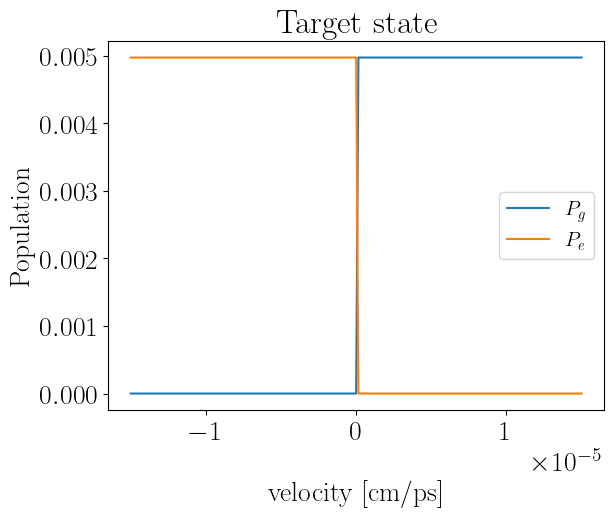

In [61]:
fig,ax = plt.subplots()
ax.set_title("Target state")
ax.plot(system.velocity_bins, ground_states_tgt,label=r"$P_g$")
ax.plot(system.velocity_bins, excited_states_tgt,label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)
#plt.savefig("figures/thesis_draft/target_state_desymmetrization.svg",bbox_inches="tight")
plt.show()

In [67]:
filename = "data/krotov/notch_red_moreTimeBins.pkl"
#old_result = krotov.result.Result().load("data/krotov/notch_red.pkl")
print("(detuning) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=200,
    #continue_from = old_result,
    store_all_pulses=True
)

opt_result.dump(filename)
old_result = opt_result     

(detuning) lambda_a = 0.01
(rabi0) lambda_b = 0.05
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     2.13e-01    0.00e+00   2.13e-01        n/a        n/a    88
1     2.11e-01    2.52e-04   2.11e-01  -2.25e-03  -2.00e-03   181
2     2.09e-01    2.35e-04   2.09e-01  -2.16e-03  -1.93e-03   192
3     2.07e-01    2.21e-04   2.07e-01  -2.09e-03  -1.86e-03   189
4     2.05e-01    2.10e-04   2.05e-01  -2.02e-03  -1.81e-03   183
5     2.03e-01    2.00e-04   2.03e-01  -1.95e-03  -1.75e-03   191
6     2.01e-01    1.91e-04   2.01e-01  -1.89e-03  -1.70e-03   194
7     1.99e-01    1.84e-04   1.99e-01  -1.84e-03  -1.65e-03   193
8     1.97e-01    1.77e-04   1.98e-01  -1.78e-03  -1.61e-03   195
9     1.96e-01    1.70e-04   1.96e-01  -1.73e-03  -1.56e-03   193
10    1.94e-01    1.64e-04   1.94e-01  -1.68e-03  -1.52e-03   197
11    1.92e-01    1.59e-04   1.93e-01  -1.64e-03  -1.48e-03   197
12    1.91e-01    1.54e-04   1.91e-01  -1.60e-03  -1.45e-03   197
13    1.89e-01    1.49e-0

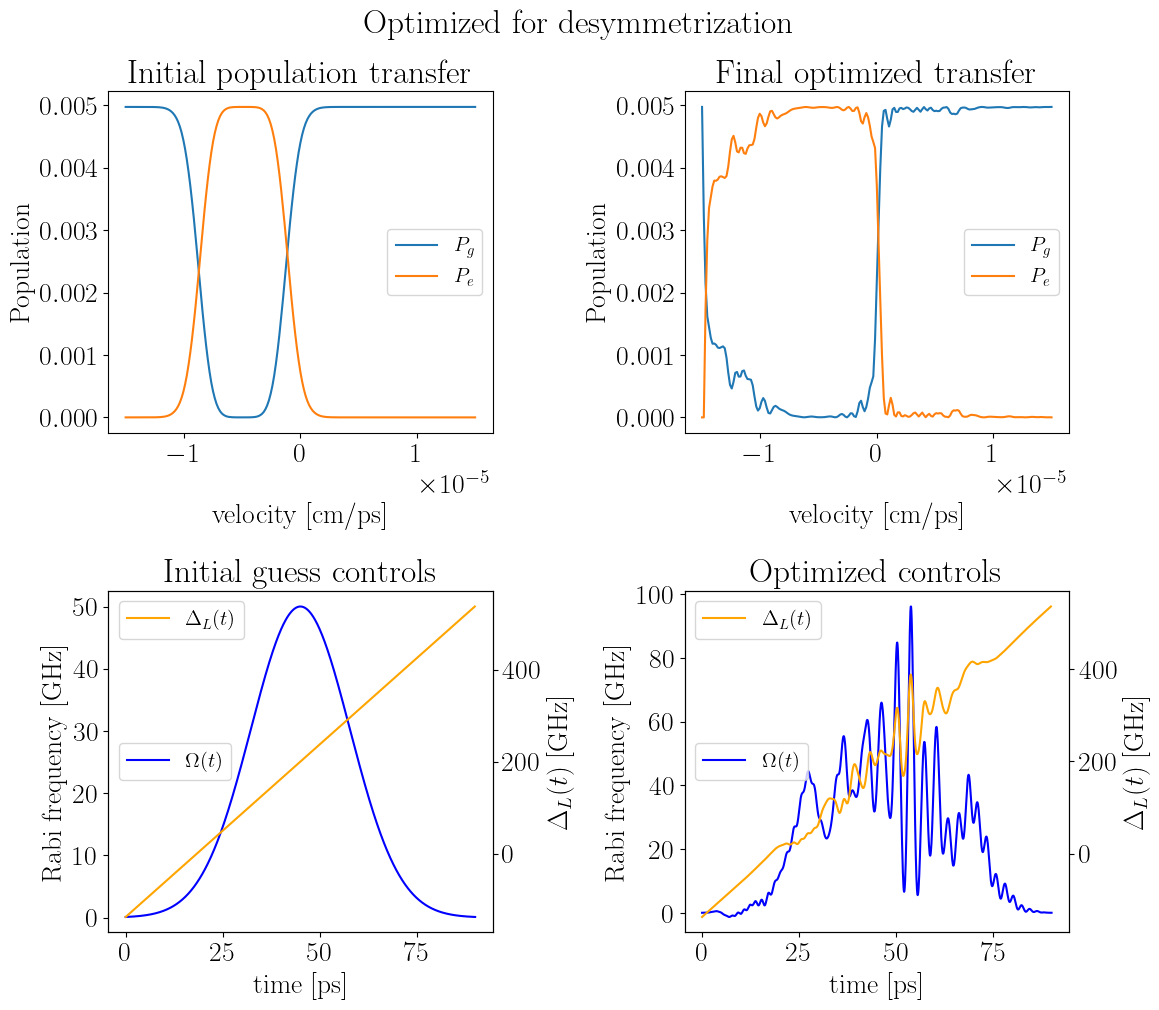

In [68]:
opt_result = krotov.result.Result().load("data/krotov/notch_red_moreTimeBins.pkl")
opt_dynamics = opt_result.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)

fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial population transfer")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized transfer")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
ax3 = axes[1,0].twinx()
ax3.plot(laser.tlist[:-1],H[1][1][:-1]*1e3/(2*np.pi),label=r"$\Delta_L(t)$",color="orange")
axes[1,0].legend(fontsize=15,loc="center left")
ax3.set_ylabel(r"$\Delta_L(t)$ [GHz]")
ax3.legend(fontsize=15,loc="upper left")

detuning = opt_result.optimized_controls[0]*1e3/(2*np.pi)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel("Rabi frequency [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist[:-2],detuning[:-2],label=r"$\Delta_L(t)$",color="orange")
ax2.set_ylabel(r"$\Delta_L(t)$ [GHz]")
axes[1,1].legend(fontsize=15,loc="center left")
ax2.legend(fontsize=15,loc="upper left")

fig.tight_layout()
fig.suptitle("Optimized for desymmetrization",y=1.02)
#plt.savefig("figures/thesis_draft/desymmetrization_flattop.svg",bbox_inches="tight")
plt.show()


In [16]:
opt_result = krotov.result.Result().load("data/krotov/notch_red.pkl")
system = Ps_system(N_atoms = 1,N_points = 100)
system.init_distribution_MB()
#system.init_distribution_flattop()
system.init_states_ground()
system.create_composite()

detuning = opt_result.optimized_controls[0]
envelope = opt_result.optimized_controls[2]
tlist = opt_result.tlist
laser_guess = {
    "label":"desymmetrization",
    "order":0,
    "scale":1000,
    "envelope":envelope,
    "detuning":detuning,
    "unit_wavevector":1,
    "tlist":tlist
}
laser = laser_new(laser_guess)
system.set_Hamiltonian_MT_general_laser(laser)

velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

# result = qt.sesolve(tlist = opt_result.tlist,psi0 = system.states,H=system.H, e_ops=system.e_ops,options=opts)
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# ax.plot(system.velocity_bins, np.asarray(result.expect)[0:150,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(result.expect)[0:150,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(result.expect)[150:300,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)
tlist = opt_result.tlist
target_velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(target_velocity_array) # move all initial velocity states 1 bin to the right
ket_1S = qt.basis(system.internal_dims,0)
ket_2P = qt.basis(system.internal_dims,1)
ground_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i >= system.N_points/2-2 else 0 for i in range(system.N_points)]))
excited_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i < system.N_points/2-2 else 0 for i in range(system.N_points)]))
target_states = (qt.tensor(ground_kets_vel,ket_1S) +qt.tensor(excited_kets_vel,ket_2P) ).unit()
# the probability that a given velocity bin is in the excited state

ground_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points)])
excited_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points,system.N_points*2)])
#print(target_states)
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = pulse_duration
t_fall = t_rise
lambda_a = 1 # detuning
lambda_b = 1 # envelope
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=pulse_duration*3, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(system.H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(system.H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(system.H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=system.states.unit(), target=target_states, H=system.H)
opts = qt.Options(store_states=True)
#unopt_result = qt.sesolve(tlist = opt_result.tlist,psi0=system.states,H=system.H,e_ops=system.e_ops,options=opts)
#test_final_states = unopt_result.states[-1]
# unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm,e_ops=system.e_ops)

# plt.plot(opt_result.tlist,system.H[1][1])
# plt.show()
# plt.plot(opt_result.tlist,system.H[3][1])
# plt.show()
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# #ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)
#print(J_T_custom([test_final_states],[objective]))

In [29]:
old_result = krotov.result.Result().load("data/krotov/notch_red_continued.pkl")
print("(detuning) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=200,
    continue_from = old_result,
    store_all_pulses=True
)

(detuning) lambda_a = 1
(rabi0) lambda_b = 1
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     1.67e-02    0.00e+00   1.67e-02        n/a        n/a    12
73    1.67e-02    8.49e-08   1.67e-02   7.61e-07   8.45e-07    23 **


In [20]:
opt_result.dump("data/krotov/notch_red_continued.pkl")
old_result = opt_result     

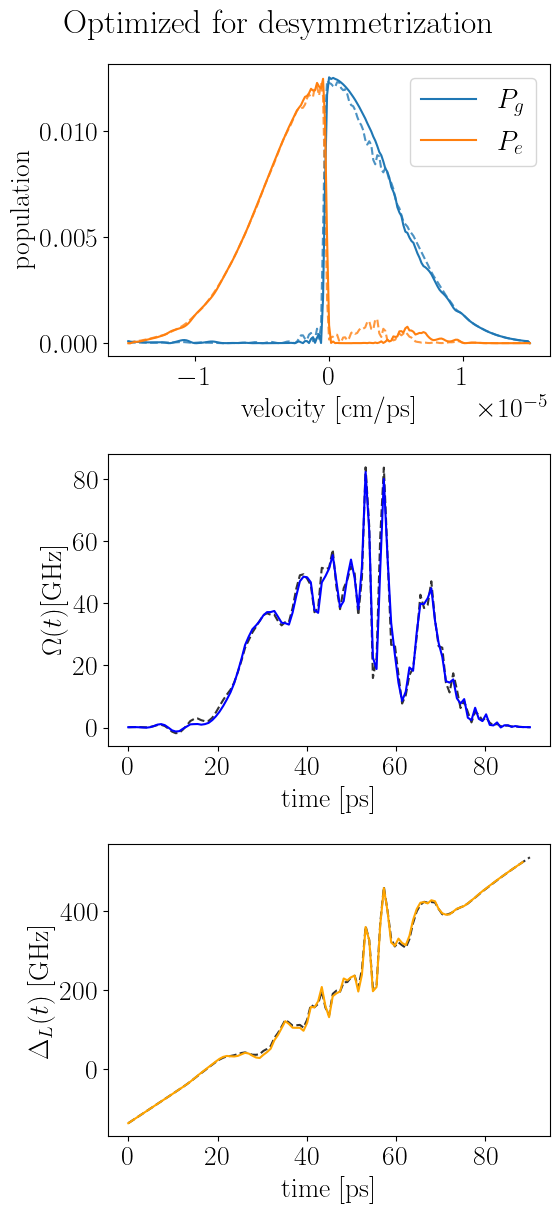

In [49]:
opt_result = krotov.result.Result().load("data/krotov/notch_red_continued.pkl")
#opt_dynamics = opt_result.optimized_objectives[0].propagate(opt_result.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
#unopt_result = objective.propagate(opt_result.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)

fig,axes = plt.subplots(3,figsize=(6,12))

axes[0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],ls="dashed",alpha=0.8)
axes[0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],ls="dashed",alpha=0.8)
axes[0].set_prop_cycle(None)
axes[0].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0].legend()
axes[0].set_xlabel("velocity [cm/ps]")
axes[0].set_ylabel("population")


axes[1].plot(opt_result.tlist,objective.H[3][1]/(2*np.pi)*1e3,color="black",ls="dashed",alpha=0.8)
axes[1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
#axes[1].legend()
axes[1].set_ylabel(r"$\Omega(t)$[GHz]")
axes[1].set_xlabel("time [ps]")

axes[2].plot(opt_result.tlist,objective.H[1][1]*1e3/(2*np.pi),color="black",ls="dashed",alpha=0.8)
axes[2].plot(laser.tlist[:-2],detuning[:-2],label=r"$\Delta_L(t)$",color="orange")
#axes[2].legend()
axes[2].set_ylabel(r"$\Delta_L(t)$ [GHz]")
axes[2].set_xlabel("time [ps]")
fig.tight_layout()
fig.suptitle("Optimized for desymmetrization",y=1.02)
#plt.savefig("figures/thesis_draft/krotov_desymmetrization_30ps_MB.svg",bbox_inches="tight")
plt.show()
